In [1]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
%matplotlib inline

# 0. Get Data

    def get_data(data_url):
        with requests.get(data_url) as r:

            with zipfile.ZipFile(io.BytesIO(r.content)) as z:
                z.extractall()

    data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

    get_data(data_url=data_url)

In [3]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [5]:
len(os.listdir(data_dir))

500

In [6]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [7]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

In [8]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [9]:
aapl_df = get_df("table_aapl.csv")

In [10]:
aapl_df.head()

,date,open,high,low_price,close,volume
date,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95


# 1. Exploratory Analysis

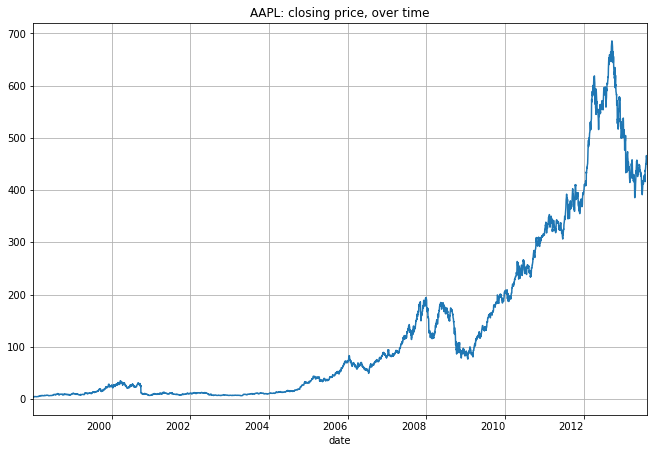

In [11]:
ax = aapl_df.close.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: closing price, over time")

**Unit Root**

A real treatment of this concept is outside of our scope today, but you can read more about it [here](https://en.wikipedia.org/wiki/Unit_root) or [here](https://faculty.chicagobooth.edu/ruey.tsay/teaching/uts/lec11-08.pdf). For now, I'll go ahead and collquially summarize the _unit root_ concept with the following ...

Many statistical models require the assumption of certain distributional properties in the data. A key assumption is that of [*stationarity*](https://en.wikipedia.org/wiki/Stationary_process), which (among other things) means that the _mean_ and _variance_ of the data do not change over time.

If you are looking at the original and not relative-change values of your data, the data's distributional parameters, i.e. _mean_ and _variance_ are likely going to change, depending on how you slice into the data.

On the other hand, if your data follows a stationary process, the way in which it _changes_ should itself not be changing. Maybe a way to think of this is: we want to model the process, or the changes in the data, and not the data's initial conditions. If you don't make take this into account, you can get some very warped results.

Thus, something you'll often see is a change from the original values to the proportionate changes, with respect to the previous period(s). In finance, that means looking at _returns_ as opposed to _prices_.

In [12]:
aapl_df["return_daily"] = aapl_df.close.pct_change()

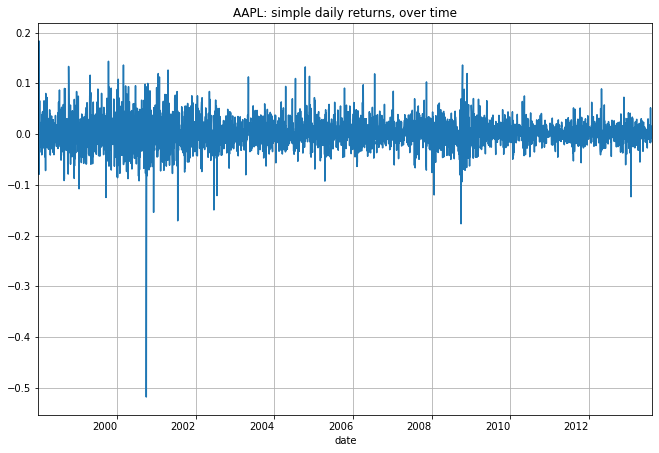

In [13]:
ax = aapl_df.return_daily.plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("AAPL: simple daily returns, over time")

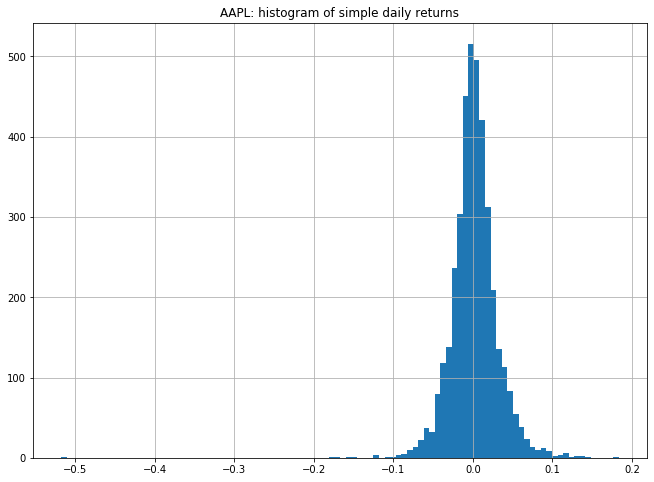

In [14]:
ax = aapl_df.return_daily.hist(bins=100, figsize=(11, 8))
g = ax.grid(True)
t = ax.title.set_text("AAPL: histogram of simple daily returns")

In [15]:
aapl_df.return_daily.rename("t"
                   ).to_frame(
                   ).join(
                        aapl_df.return_daily.shift(1).rename("t-1")
                   ).corr()

,t,t-1
t,1.000000,-0.034992
t-1,-0.034992,1.000000


### --

### Problem

- get _autocorrelation_ going back through 30 lags
- plot the results - make sure to label your plot

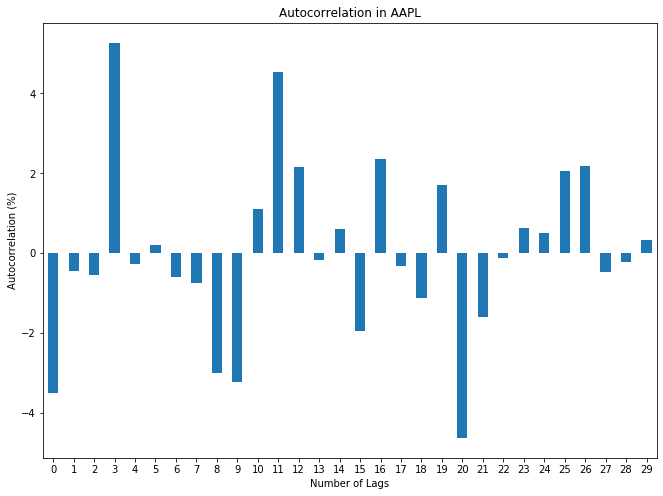

In [16]:
aapl_autocorr = pd.Series([aapl_df.return_daily.rename("t"
                                               ).to_frame(
                                               ).join(
                                                    aapl_df.return_daily.shift(i).rename("t-1")
                                               ).corr().iloc[1, 0]
                                for i in range(1, 31)],
                                name="Autocorrelation in AAPL"
                                     )

ax = aapl_autocorr.multiply(100).plot.bar(figsize=(11, 8), rot=0)

t = ax.set_title(aapl_autocorr.name)
xlab = ax.set_xlabel("Number of Lags")
ylab = ax.set_ylabel("Autocorrelation (%)")

### --

### Monthly Returns

In [17]:
aapl_df["year"] = aapl_df.date.dt.year

In [18]:
aapl_df["month"] = aapl_df.date.dt.month

In [19]:
aapl_df["return_daily_gross"] = aapl_df.return_daily + 1

In [20]:
aapl_df.head()

,date,open,high,low_price,close,volume,return_daily,year,month,return_daily_gross
date,,,,,,,,,,
1998-01-02,1998-01-02,3.31397,3.95098,3.28236,3.95098,24947201.10,NaN,1998,1,NaN
1998-01-05,1998-01-05,4.01177,4.02635,3.69325,3.89020,22344145.08,-0.015384,1998,1,0.984616
1998-01-06,1998-01-06,3.87561,4.98432,3.58628,4.60502,63150252.55,0.183749,1998,1,1.183749
1998-01-07,1998-01-07,4.57341,4.68040,4.20871,4.24032,36978255.52,-0.079196,1998,1,0.920804
1998-01-08,1998-01-08,4.24032,4.52965,4.11875,4.39107,27687622.95,0.035552,1998,1,1.035552


In [21]:
aapl_monthly = aapl_df.groupby(["year", "month"]).return_daily_gross.prod()

In [22]:
aapl_monthly.shape

(188,)

In [23]:
aapl_monthly = aapl_monthly.rename("return_t")

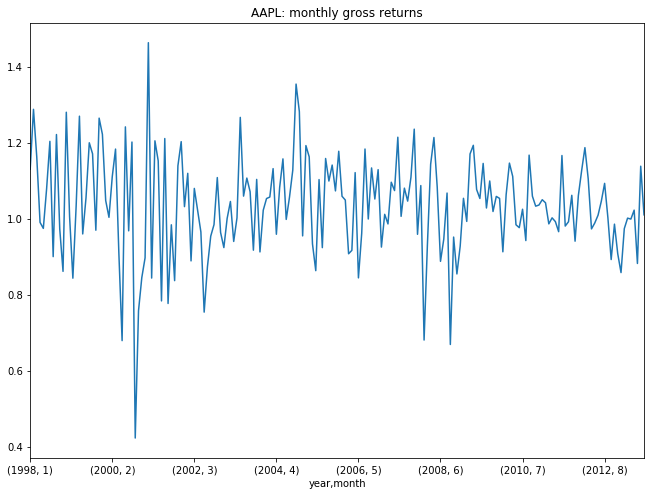

In [24]:
ax = aapl_monthly.plot(figsize=(11, 8))
t = ax.set_title("AAPL: monthly gross returns")

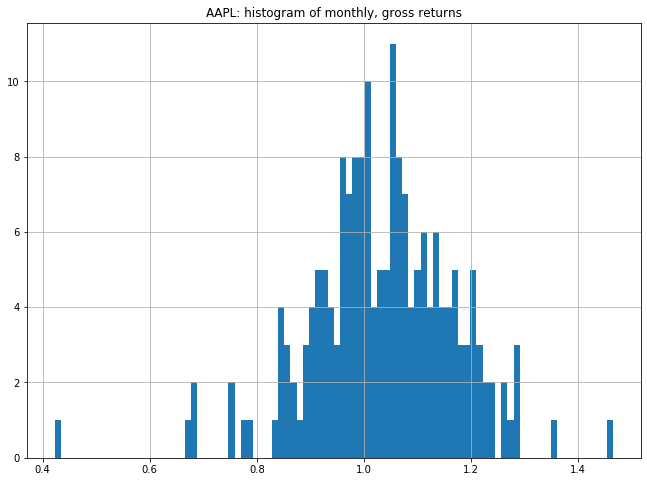

In [25]:
ax = aapl_monthly.hist(bins=90, figsize=(11, 8))
t = ax.title.set_text("AAPL: histogram of monthly, gross returns")

In [26]:
aapl_monthly = aapl_monthly.to_frame()

In [27]:
aapl_monthly["return_t_minus_1"] = aapl_monthly.return_t.shift(1)

In [28]:
aapl_monthly.corr()

,return_t,return_t_minus_1
return_t,1.000000,0.028486
return_t_minus_1,0.028486,1.000000


In [29]:
aapl_df = aapl_df.join(
                    aapl_df.return_daily_gross.rolling(21
                                             ).apply(np.prod, raw=True
                                             ).rename("return_daily_rolling_21")
                    -1 )

In [30]:
aapl_df.return_daily.to_frame().join(aapl_df.return_daily_rolling_21.shift(1)).corr()

,return_daily,return_daily_rolling_21
return_daily,1.000000,-0.005484
return_daily_rolling_21,-0.005484,1.000000


In [31]:
aapl_df = aapl_df.join(
                    aapl_df.return_daily_gross.rolling(63
                                             ).apply(np.prod, raw=True
                                             ).rename("return_daily_rolling_63")
                    -1 )

In [32]:
aapl_df.return_daily.to_frame().join(aapl_df.return_daily_rolling_63.shift(1)).corr()

,return_daily,return_daily_rolling_63
return_daily,1.000000,0.015047
return_daily_rolling_63,0.015047,1.000000


In [33]:
aapl_df = aapl_df.join(
                    aapl_df.return_daily_gross.rolling(63
                                             ).std(
                                             ).rename("return_vol_rolling_63")
                    -1 )

In [34]:
aapl_df.return_daily.to_frame().join(aapl_df.return_vol_rolling_63.shift(1)).corr()

,return_daily,return_vol_rolling_63
return_daily,1.000000,-0.032769
return_vol_rolling_63,-0.032769,1.000000


### --

### Problem
- engineer some more features to use and evaluate their performance
- could look at cumulative, rolling returns; could pull in another stock's performance; etc.

### --

# 2. First Pass at Predictive Modeling

### Feature Engineering

In [35]:
def get_shifted(srs, shift_start, shift_end):
    """
    Returns a df, with each column corresponding to `srs` being shifted,
    starting with `shift_start` number of shifts and going through
    `shift_end`.
    """
    return pd.concat([
                        srs.shift(i).rename(f"{srs.name}_shifted_{i}")
                        for i in range(shift_start, shift_end + 1)
            ], axis=1)

In [36]:
aapl_features = get_shifted(aapl_df.return_daily, 1, 21)

In [37]:
aapl_features.shape

(3926, 21)

In [38]:
aapl_features = aapl_features.join(
                    aapl_df[[
                        "return_daily_rolling_21",
                        "return_daily_rolling_63",
                        "return_vol_rolling_63"
                    ]])

In [39]:
aapl_features.shape

(3926, 24)

In [40]:
aapl_features = aapl_features.join(aapl_df.month)

### Train / Test

In [41]:
train = aapl_df.loc[
                (aapl_df.year == 2009)
                &
                (aapl_df.month < 10)
                    ].index

In [42]:
test = aapl_df.loc[
                (aapl_df.year == 2009)
                &
                (aapl_df.month >= 10)
                    ].index

In [43]:
X_train = aapl_features.loc[train]

In [44]:
X_test = aapl_features.loc[test]

In [45]:
y_train = aapl_df.loc[train, "return_daily"]

In [46]:
y_train.shape

(188,)

In [47]:
y_test = aapl_df.loc[test, "return_daily"]

In [48]:
y_test.shape

(64,)

In [49]:
aapl_features.columns.tolist()

['return_daily_shifted_1',
 'return_daily_shifted_2',
 'return_daily_shifted_3',
 'return_daily_shifted_4',
 'return_daily_shifted_5',
 'return_daily_shifted_6',
 'return_daily_shifted_7',
 'return_daily_shifted_8',
 'return_daily_shifted_9',
 'return_daily_shifted_10',
 'return_daily_shifted_11',
 'return_daily_shifted_12',
 'return_daily_shifted_13',
 'return_daily_shifted_14',
 'return_daily_shifted_15',
 'return_daily_shifted_16',
 'return_daily_shifted_17',
 'return_daily_shifted_18',
 'return_daily_shifted_19',
 'return_daily_shifted_20',
 'return_daily_shifted_21',
 'return_daily_rolling_21',
 'return_daily_rolling_63',
 'return_vol_rolling_63',
 'month']

### Additional Prep

In [50]:
X_train.dtypes.value_counts()

float64    24
int64       1
dtype: int64

In [51]:
scaler = StandardScaler()

In [52]:
float_cols = X_train.select_dtypes(include=float).columns

In [53]:
X_train.loc[:, float_cols] = scaler.fit_transform(X_train.loc[:, float_cols])

In [54]:
X_test.loc[:, float_cols] = scaler.fit_transform(X_test.loc[:, float_cols])

### `LinearRegression` 

In [55]:
linreg = LinearRegression()

In [56]:
linreg = linreg.fit(X_train, y_train)

In [57]:
linreg.score(X_train, y_train)

0.9480997046474106

In [58]:
linreg.score(X_test, y_test)

-1.1086292410723533

### `Ridge` 
- in *Ridge regression*, something called *L2 normalization* is applied
- [this](https://en.wikipedia.org/wiki/Tikhonov_regularization) will force coefficients to stay close to 0, which helps to prevent overfitting
- in `sklearn`, we control this value with the `alpha` hyper parameter
- the higher the value of `alpha`, the higher the regularization; tuning in powers of ten is common

In [59]:
ridge = Ridge(alpha=10)

In [60]:
ridge = ridge.fit(X_train, y_train)

In [61]:
ridge.score(X_train, y_train)

0.5620129221780635

In [62]:
ridge.score(X_test, y_test)

0.4570863648300462

### Visualize Predictions

In [63]:
y_test_pred = ridge.predict(X_test)

In [65]:
y_test = y_test.rename("y_test").to_frame()

In [66]:
y_test["y_pred"] = y_test_pred

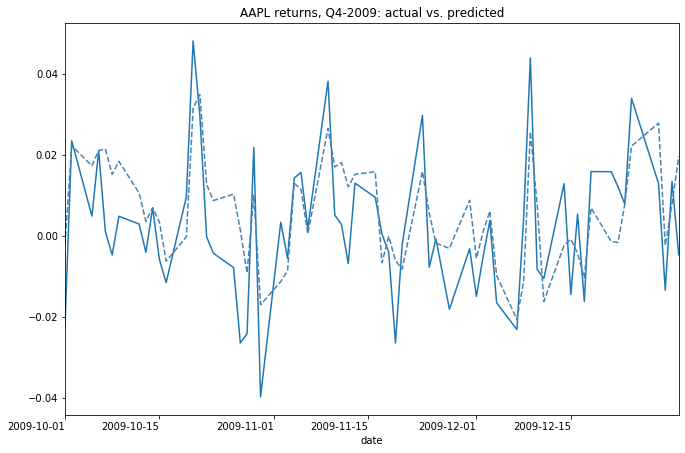

In [105]:
ax = y_test.y_test.plot(figsize=(11, 8), rot=0)
ax = y_test.y_pred.plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, Q4-2009: actual vs. predicted")

# 3. Walk-Forward Validation

Just as in cross-sectional modeling, where *cross validation* is used, we want unbiased estimations of model performance. In time-series modeling, however, we need to be very careful not to leak data, which can be easy to do when there is a strict chronology. So, we run train / test splits over different parts of the data, where train _always_ comes before test.

Specifically:

- we run run a number of trials of this splitting on a validation part of the data
- this is where we make decisions around features to use, hyper-parameter tuning, etc.
- then, on a _later_ chunk of the data, we'll run some more trials, where we make no changes, and these are the numbers we report
- we can use 3, 5, 10, etc. trials in each of the validation and test sets, just like in classic CV
- and we use the mean (and maybe, standard deviation) across these trials for our decision making and results reporting


### --

### Problem

- write a program to perform walk-forward validation
- use this program to help you in your model selection - i.e. in selecting features to use, hyper-parameter values to set

The core functionality should work as follows. It should take as parameters something like:
- `model_obj`
- `data`
- `X_cols`
- `y_col`
- `start_year`
- `start_quarter`

I've given you some default values to get you going, but you don't need to use those. As for what the program should return, there are plenty of nice formatting tricks you could get into, but the core of it is, you'll have an `np.array` or `pd.DataFrame` of predictions, and for each prediction you'll want to make sure you're keeping track of:
- the date the prediction is for
- the trial number

That process will be the same for each of the validation and test chunks. Remember that there are _two_ layers of splitting; this functionality is for the inner layer. If you want to wrap this in something to handle the outer layer as well, you can, but start with the inner layer.

In [107]:
aapl_df["quarter"] = aapl_df.date.dt.quarter

In [135]:
aapl_df = aapl_df.join(aapl_features[list(set(aapl_features.columns) - set(aapl_df.columns))])

In [224]:
def time_series_validation(
                            model_obj,
                            data,
                            X_cols,
                            y_col,
                            start_year,
                            start_quarter,
                            num_trials=3
                         ):
    
    # first, some data prep
    data = data.copy()
    data = data.sort_index()
    
    
    # get validation boundaries
    start_inds = data.loc[
                (data.year == start_year)
                & (data.quarter == start_quarter),
                    :].index.min()
    
    data = data.loc[start_inds:, :]
    
    year_quarters = data[["year", "quarter"]].drop_duplicates()
    year_quarters = year_quarters[:4 + num_trials]
    
    end_year_quarter = year_quarters.iloc[-1]
    end_year = end_year_quarter[0]
    end_quarter = end_year_quarter[1]
    
    # set up results list
    results = []
    
    # run the validation trials
    for i in range(len(year_quarters)):
        if i == num_trials:
            break

        train_year_quarters = year_quarters[i:i+3]
        test_year_quarter = year_quarters.iloc[i+3]

        train_start_year, train_start_quarter = train_year_quarters.iloc[0]
        train_end_year, train_end_quarter = train_year_quarters.iloc[-1]
        
        train_inds = data.loc[(
                (data.year >= train_start_year)
                    & (data.quarter >= train_start_quarter)
                ) | (
                (data.year <= train_end_year)
                    & (data.quarter <= train_end_quarter)
            ), :].index
        
        test_inds = data.loc[
                (data.year == test_year_quarter.year)
                & (data.quarter == test_year_quarter.quarter),
                    :].index

        X_train = data.loc[train_inds, X_cols].astype(float)
        y_train = data.loc[train_inds, y_col]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        model_obj = model_obj.fit(X_train, y_train)

        X_test = data.loc[test_inds, X_cols].astype(float)
        y_test = data.loc[test_inds, y_col]
        
        X_test = scaler.fit_transform(X_test)
        y_test_pred = model_obj.predict(X_test)
        
        y_test = y_test.rename("y_test").to_frame()
        y_test["y_pred"] = y_test_pred

        results.append(trial_results)
    
    df = pd.concat(results)
    
    return df

### --

In [220]:
results = time_series_validation(
                                   Ridge(alpha=10),
                                   aapl_df,
                                   X_cols=aapl_features.columns,
                                   y_col="return_daily",
                                   start_year=2008,
                                   start_quarter=2
                            )

In [226]:
results.head()

,y_test,y_pred
date,,
2009-01-02,0.056930,0.012667
2009-01-05,0.043378,0.006848
2009-01-06,-0.016503,-0.014871
2009-01-07,-0.022481,-0.024702
2009-01-08,0.019147,-0.010358


In [227]:
results = results.sort_index()

In [228]:
r2_score(results.y_test, results.y_pred)

0.32267887538275086

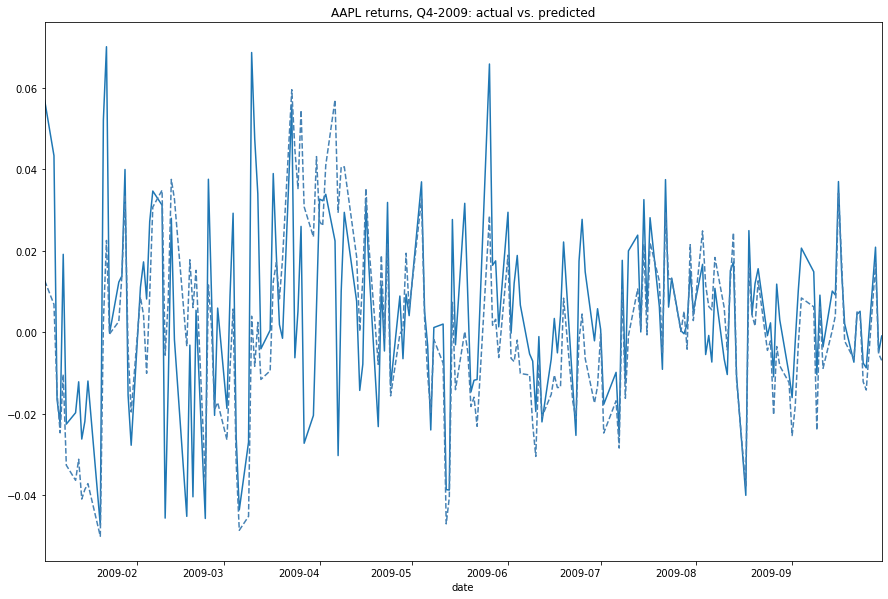

In [231]:
ax = results.y_test.plot(figsize=(15, 11), rot=0)
ax = results.y_pred.plot(ax=ax, color="steelblue", linestyle="--", rot=0)
t = ax.title.set_text("AAPL returns, Q4-2009: actual vs. predicted")

**Notes**

- do we want to return some predictions + dates, and then aggregate after?
- yes, that's what you want to do

# 4. Classic Time-Series Model Frameworks

### AR

### ARIMA 

### ARCH

### GARCH

### --

### Problem
- write a wrapper for your walk-foward functionality, which will allow you to iterate through different models

### --